In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd


In [2]:
# Load in Graph and Artist Data
with open("./saved_objects/main_graph.pkl", "rb") as f:
    G = pickle.load(f)
with open("./saved_objects/artist_info.pkl", "rb") as f:
    artist_info = pickle.load(f)

# 3. Community Detection and Identification
...

In [3]:
# Detect communities with the Louvain Algorithm
all_communities = nx.community.louvain_communities(G)
print("Number of communties: ", len(all_communities))

Number of communties:  122


In [4]:
# Compute modularity score to assess partitioning
modularity = nx.community.modularity(G, all_communities, weight='weight', resolution=1)
print("Network Modularity: ",modularity) # Quite high, indicates strong community structure

Network Modularity:  0.7793796318453486


Filter the communties via an artist size threshhold to remove less relevent communities. \
Then, create a list of the communties as subgraphs to perform sugraph analysis

In [5]:

# Filter communties by size threshhold, then sort
MIN_COMM_SIZE = 200

# This will be the list of commuties we will reference from here on out
communities = sorted([comm for comm in all_communities if len(comm) >= MIN_COMM_SIZE], key=len, reverse=True)
print("Number of communties (filtered): ", len(communities))

# Create a list of community subgraphs for further analysis
comm_subgraphs = [G.subgraph(comm) for comm in communities]

# Save Objects
with open("./saved_objects/community_subgraphs.pkl", "wb") as f:
    pickle.dump(comm_subgraphs, f)
with open("./saved_objects/community_node_sets.pkl", "wb") as f:
    pickle.dump(communities, f)

Number of communties (filtered):  36


## _Density Measures_

Compute density measures for each community, all indexed the same. Produce and analyze global measures

In [6]:

# List of community density measures by index
comm_sizes = [len(comm) for comm in communities]
edge_densities = [nx.density(comm_sub) for comm_sub in comm_subgraphs]
avg_cluster_coeffs = [np.mean(list(nx.clustering(comm_sub).values())) for comm_sub in comm_subgraphs]
conductances = [nx.algorithms.conductance(G, comm) for comm in communities]

# # Save Objects
# with open("./saved_objects/communities_by_sizes.pkl", "wb") as f:
#     pickle.dump(comm_sizes, f)
# with open("./saved_objects/communities_by_edge_densities.pkl", "wb") as f:
#     pickle.dump(edge_densities, f)
# with open("./saved_objects/communities_by_avg_cluster_coeffs.pkl", "wb") as f:
#     pickle.dump(avg_cluster_coeffs, f)
# with open("./saved_objects/communities_by_conductances.pkl", "wb") as f:
#     pickle.dump(conductances, f)
    

print("Average Conductance: ", np.mean(conductances))
print("Min Conductance: ", min(conductances))
print("Max Conductance: ",max(conductances))
print()
# Very low average conductance shows strong community cohesion
print("Average relative edge density: ", np.mean(edge_densities))
print("Min relative edge density: ", min(edge_densities))
print("Max relative edge density: ",max(edge_densities))
print()

print("Mean of Means Clustering Coefficent: ", np.mean(avg_cluster_coeffs))
print("Min Average Clustering Coefficent: ", min(avg_cluster_coeffs))
print("Max Average Clustering Coefficent: ",max(avg_cluster_coeffs))
print()

Average Conductance:  0.11498285796894556
Min Conductance:  0.015427769985974754
Max Conductance:  0.29674689235651946

Average relative edge density:  0.0036007770238725037
Min relative edge density:  0.0004142450278922475
Max relative edge density:  0.008164577306332368

Mean of Means Clustering Coefficent:  0.11161805336537439
Min Average Clustering Coefficent:  0.004497354497354496
Max Average Clustering Coefficent:  0.2057690916632081



Plot local community density measures and compare to eachother

C:\Users\jesse\AppData\Local\Temp\ipykernel_22676\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_22676\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_22676\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_22676\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


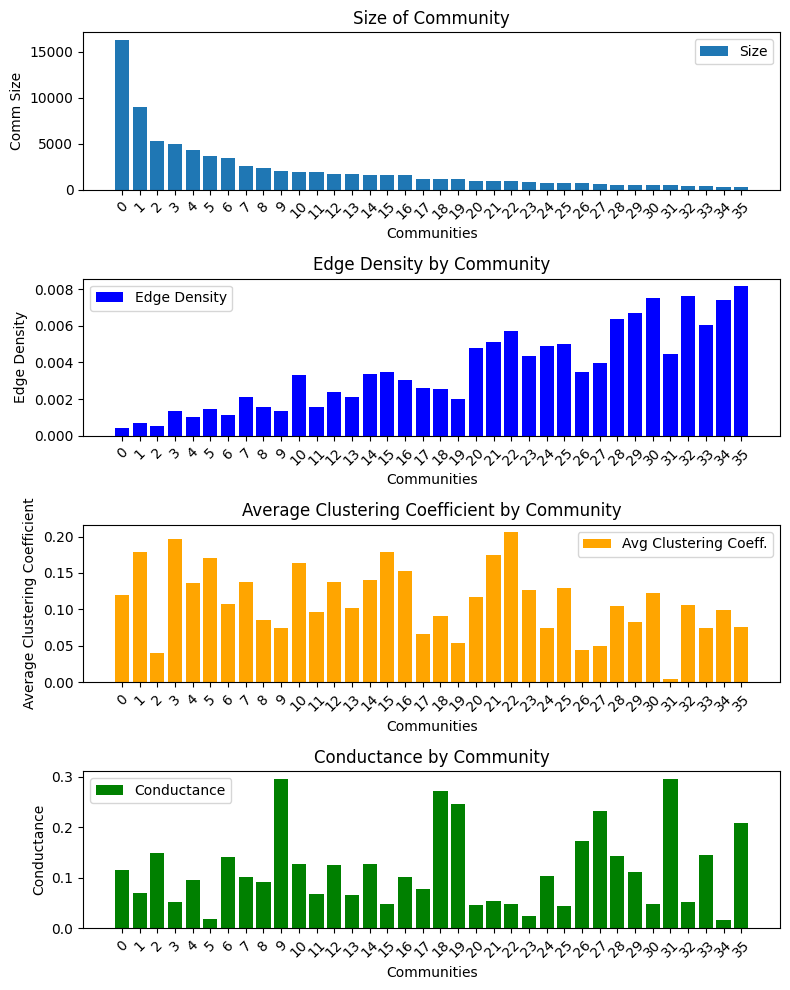

In [7]:
labels = [f"{i}" for i in range(len(edge_densities))]
x = np.arange(len(labels))  # the label locations

fig, axs = plt.subplots(4, 1, figsize=(8, 10))  # Increased figure size

# Plot for Comm Size
axs[0].bar(labels, comm_sizes, label='Size')
axs[0].set_ylabel('Comm Size')
axs[0].set_title('Size of Community')
axs[0].legend()

# Plot for Edge Density
axs[1].bar(labels, edge_densities, color='b', label='Edge Density')
axs[1].set_ylabel('Edge Density')
axs[1].set_title('Edge Density by Community')
axs[1].legend()

# Plot for Average Clustering Coefficient
axs[2].bar(labels, avg_cluster_coeffs, color='orange', label='Avg Clustering Coeff.')
axs[2].set_ylabel('Average Clustering Coefficient')
axs[2].set_title('Average Clustering Coefficient by Community')
axs[2].legend()

# Plot for Conductance
axs[3].bar(labels, conductances, color='g', label='Conductance')
axs[3].set_ylabel('Conductance')
axs[3].set_title('Conductance by Community')
axs[3].legend()

for ax in axs:
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel('Communities')

fig.tight_layout()  # Adjust layout to make sure everything fits without overlap

plt.show()
# Clearly we can see no relation between size and conductance

## _Community Identification and Genre Labal Analysis_

Get top 5 genres per community, to identify. 

In [12]:
from collections import Counter
def get_top_genres_by_community(comms):
    genres_by_community = []

    for comm in comms:
        comm_genres = []
        for node in comm:
            comm_genres.extend(artist_info[node][2])  # Assuming artist_info[node][2] holds genre info
        genres_by_community.append(comm_genres)

    top_five_genres_per_comm = []
    for genres in genres_by_community:
        genre_counter = Counter(genres)
        top_five_genres = genre_counter.most_common(5)
        top_five_genres_per_comm.append({genre: count for genre, count in top_five_genres})

    return top_five_genres_per_comm, genres_by_community


def display_top_genres(data):

    data = {f"Comm. {i+1}": [f"{genre} ({count} times)" for genre, count in genres.items()] 
            for i, genres in enumerate(data)}

    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)

    df = pd.DataFrame(data, index=[f"Top {i+1}" for i in range(5)]).T
    df.index.name = 'Community'
    df.columns.name = 'Rank'

    print(df)

top_five_genres_per_comm, genres_by_community = get_top_genres_by_community(communities)
display_top_genres(top_five_genres_per_comm)

# Save
with open("./saved_objects/genres_by_community.pkl", "wb") as f:
    pickle.dump(top_five_genres_per_comm, f)


Rank                                   Top 1                               Top 2                           Top 3                              Top 4                                 Top 5
Community                                                                                                                                                                                
Comm. 1                      pop (458 times)           electro house (450 times)                 rap (415 times)              dance pop (411 times)                       edm (400 times)
Comm. 2              trap latino (299 times)               latin pop (260 times)           reggaeton (254 times)         reggaeton flow (238 times)             latin hip hop (214 times)
Comm. 3    classical performance (235 times)                 country (136 times)     adult standards (131 times)              classical (117 times)               mellow gold (116 times)
Comm. 4             funk carioca (342 times)                funk mtg (

From this we learn that regionality is a huge factor in community separation, more so than even genre. In addition we see the dominance of hip hop across all communities. 

---

Analyze number of unique genres as compared to size of community. 

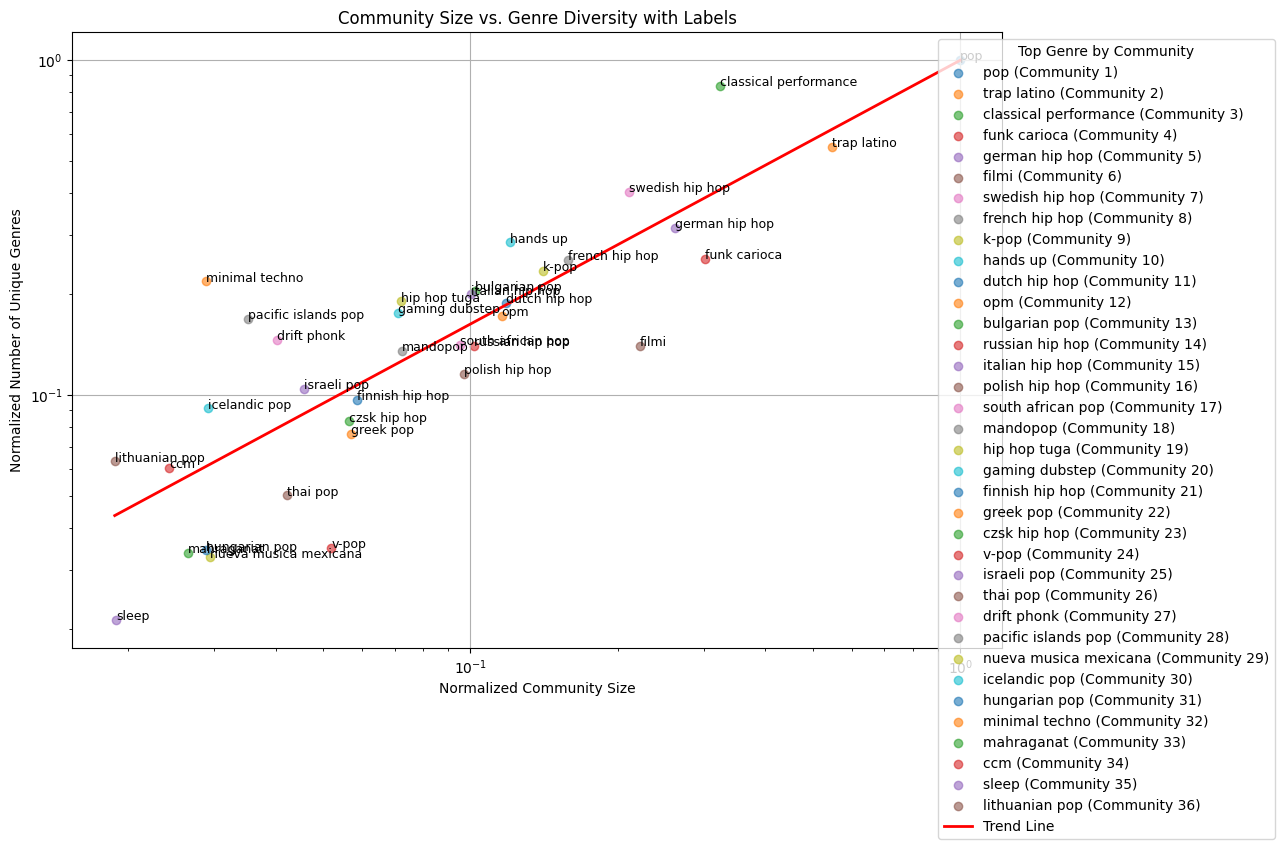

In [13]:
# Assuming genre_counts captures the most frequent genre for each community
top_genres = [max(set(genres), key=genres.count) for genres in genres_by_community]  # Most frequent genre per community

# Example data structure updates
community_sizes = [len(comm) for comm in communities]
genre_counts = [len(set(genres)) for genres in genres_by_community]

# Normalize data for better visualization
normalized_sizes = np.array(community_sizes) / max(community_sizes)
normalized_genre_counts = np.array(genre_counts) / max(genre_counts)

# Create a scatter plot
plt.figure(figsize=(12, 8))
for i in range(len(normalized_sizes)):
    plt.scatter(normalized_sizes[i], normalized_genre_counts[i], alpha=0.6, label=f'{top_genres[i]} (Community {i+1})')
    plt.text(normalized_sizes[i], normalized_genre_counts[i], f'{top_genres[i]}', fontsize=9)

slope, intercept = np.polyfit(np.log(normalized_sizes), np.log(normalized_genre_counts), 1)
line = np.exp(intercept) * normalized_sizes ** slope
plt.plot(normalized_sizes, line, color='red', linewidth=2, label='Trend Line')

# Add titles and labels
plt.title('Community Size vs. Genre Diversity with Labels')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Normalized Community Size')
plt.ylabel('Normalized Number of Unique Genres')
plt.legend(title="Top Genre by Community", loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the plot
plt.grid(True)
plt.show()


Identify the most dense communities

In [15]:

# Print top 5 genres for each of the top 5 communities by each metric
print("Top 5 Genres by Community Size:")
size_indices = np.argsort(comm_sizes)[::-1][:5]  # Get indices of the top 5 by size
for idx in size_indices:
    print(f"\t {comm_sizes[idx]}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Edge Density:")
density_indices = np.argsort(edge_densities)[::-1][:5]  # Get indices of the top 5 by edge density
for idx in density_indices:
    print(f"\t {edge_densities[idx]:.4f}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Clustering Coefficient:")
clustering_indices = np.argsort(avg_cluster_coeffs)[::-1][:5]  # Get indices of the top 5 by clustering coefficient
for idx in clustering_indices:
    print(f"\t {avg_cluster_coeffs[idx]:.2f}: {top_five_genres_per_comm[idx]}")

print("\nBottom 5 Genres by Conductance:")
conductance_indices = np.argsort(conductances)[:5]  # Get indices of the lowest 5 by conductance (better if lower)
for idx in conductance_indices: 
    print(f"\t {conductances[idx]:.2f}: {top_five_genres_per_comm[idx]}")

Top 5 Genres by Community Size:
	 16296: {'pop': 458, 'electro house': 450, 'rap': 415, 'dance pop': 411, 'edm': 400}
	 8934: {'trap latino': 299, 'latin pop': 260, 'reggaeton': 254, 'reggaeton flow': 238, 'latin hip hop': 214}
	 5278: {'classical performance': 235, 'country': 136, 'adult standards': 131, 'classical': 117, 'mellow gold': 116}
	 4909: {'funk carioca': 342, 'funk mtg': 244, 'sertanejo pop': 170, 'funk ostentacao': 165, 'brazilian hip hop': 145}
	 4264: {'german hip hop': 424, 'german underground rap': 193, 'german pop': 183, 'german trap': 181, 'turkish pop': 176}

Top 5 Genres by Edge Density:
	 0.0082: {'lithuanian pop': 84, 'lithuanian hip hop': 21, 'lithuanian edm': 17, 'lithuanian trap': 12, 'lithuanian electronic': 8}
	 0.0076: {'mahraganat': 53, 'egyptian hip hop': 46, 'egyptian trap': 34, 'arab pop': 34, 'khaliji': 33}
	 0.0075: {'hungarian pop': 127, 'hungarian hip hop': 69, 'magyar trap': 63, 'magyar alternative': 28, 'hungarian underground rap': 24}
	 0.0074: 

Least dense communities

In [16]:
print("Bottom 5 Genres by Community Size:")
size_indices = np.argsort(comm_sizes)[:5]
for idx in size_indices:
    print(f"\t {comm_sizes[idx]}: {top_five_genres_per_comm[idx]}")

print("\nBottom 5 Genres by Edge Density:")
density_indices = np.argsort(edge_densities)[:5]
for idx in density_indices:
    print(f"\t {edge_densities[idx]:.4f}: {top_five_genres_per_comm[idx]}")

print("\nBottom 5 Genres by Clustering Coefficient:")
clustering_indices = np.argsort(avg_cluster_coeffs)[:5] 
for idx in clustering_indices:
    print(f"\t {avg_cluster_coeffs[idx]:.2f}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Conductance:")
conductance_indices = np.argsort(conductances)[::-1][:5]  
for idx in conductance_indices: 
    print(f"\t {conductances[idx]:.2f}: {top_five_genres_per_comm[idx]}")

Bottom 5 Genres by Community Size:
	 306: {'lithuanian pop': 84, 'lithuanian hip hop': 21, 'lithuanian edm': 17, 'lithuanian trap': 12, 'lithuanian electronic': 8}
	 308: {'sleep': 98, 'environmental': 28, 'lullaby': 21, 'sound': 13, 'water': 10}
	 395: {'ccm': 55, 'latin christian': 45, 'latin worship': 41, 'rap cristiano': 33, 'worship': 33}
	 432: {'mahraganat': 53, 'egyptian hip hop': 46, 'egyptian trap': 34, 'arab pop': 34, 'khaliji': 33}
	 471: {'minimal techno': 36, 'electronica': 34, 'tech house': 32, 'microhouse': 30, 'minimal tech house': 14}

Bottom 5 Genres by Edge Density:
	 0.0004: {'pop': 458, 'electro house': 450, 'rap': 415, 'dance pop': 411, 'edm': 400}
	 0.0005: {'classical performance': 235, 'country': 136, 'adult standards': 131, 'classical': 117, 'mellow gold': 116}
	 0.0007: {'trap latino': 299, 'latin pop': 260, 'reggaeton': 254, 'reggaeton flow': 238, 'latin hip hop': 214}
	 0.0010: {'german hip hop': 424, 'german underground rap': 193, 'german pop': 183, 'germ

## _Run Louvain Algorithm Again on largest cluster_

In [17]:
largest_comm = comm_subgraphs[0]

sub_comms = nx.community.louvain_communities(largest_comm)
print("Number of communties: ", len(sub_comms))

modularity = nx.community.modularity(largest_comm, sub_comms, weight='weight', resolution=1)
print("Network Modularity: ",modularity) # Much lower modularity, but to be expected

Number of communties:  16
Network Modularity:  0.5098930862809917


In [18]:
# Sort by size
sub_comms = sorted([comm for comm in sub_comms], key=len, reverse=True)
print(len(sub_comms))

# Get genres
sub_comm_genres, _ = get_top_genres_by_community(sub_comms)
# Clip if not at least 4 unique genres
sub_comm_genres = [comm for comm in sub_comm_genres if len(comm) > 4]

display_top_genres(sub_comm_genres)


16
Rank                                Top 1                           Top 2                          Top 3                               Top 4                              Top 5
Community                                                                                                                                                                      
Comm. 1                   rap (388 times)                trap (321 times)            hip hop (282 times)        southern hip hop (247 times)                pop rap (243 times)
Comm. 2            uk hip hop (195 times)              uk pop (175 times)           uk drill (152 times)                   house (134 times)              pop dance (133 times)
Comm. 3         electro house (165 times)                 edm (137 times)  progressive house (135 times)               pop dance (122 times)                pop edm (107 times)
Comm. 4           electronica (125 times)    alternative dance (89 times)          indie soul (85 times)             

Sub communities are still very diverse. They contain more breakdown based on genre rather than region, though regionalism (uk pop) is still present. This suggests that clearcut communities by genre doesn't exist in the way that we thought. 

Additionally, we notices that occasionally (though rarely) the rap/hip hop subcategory would be allocated by louvain as its own major community, drastically shrinking the size of the largest community. This shows that this large community is relatively loosely tied together. It also shows that potentially rap artist have so many collaborations with artists outside their genre, that the identify of the hiphop genre itself is looser. Perhaps analyzing a network were collaborations are by individual songs, more precise detail can be revealed.

In [26]:
# Get sizes and conductances of comms

sub_comm_conductances = [nx.algorithms.conductance(largest_comm, comm) for comm in sub_comms]
sub_comm_sizes = [len(comm) for comm in sub_comms]

# Much higher conductance values
print("Average Conductance: ", np.mean(sub_comm_conductances))
print("Min Conductance: ", min(sub_comm_conductances))
print("Max Conductance: ",max(sub_comm_conductances))
print()

Average Conductance:  0.4418963961950867
Min Conductance:  0.15100357614613874
Max Conductance:  0.559322033898305



C:\Users\jesse\AppData\Local\Temp\ipykernel_22676\3807607231.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_22676\3807607231.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


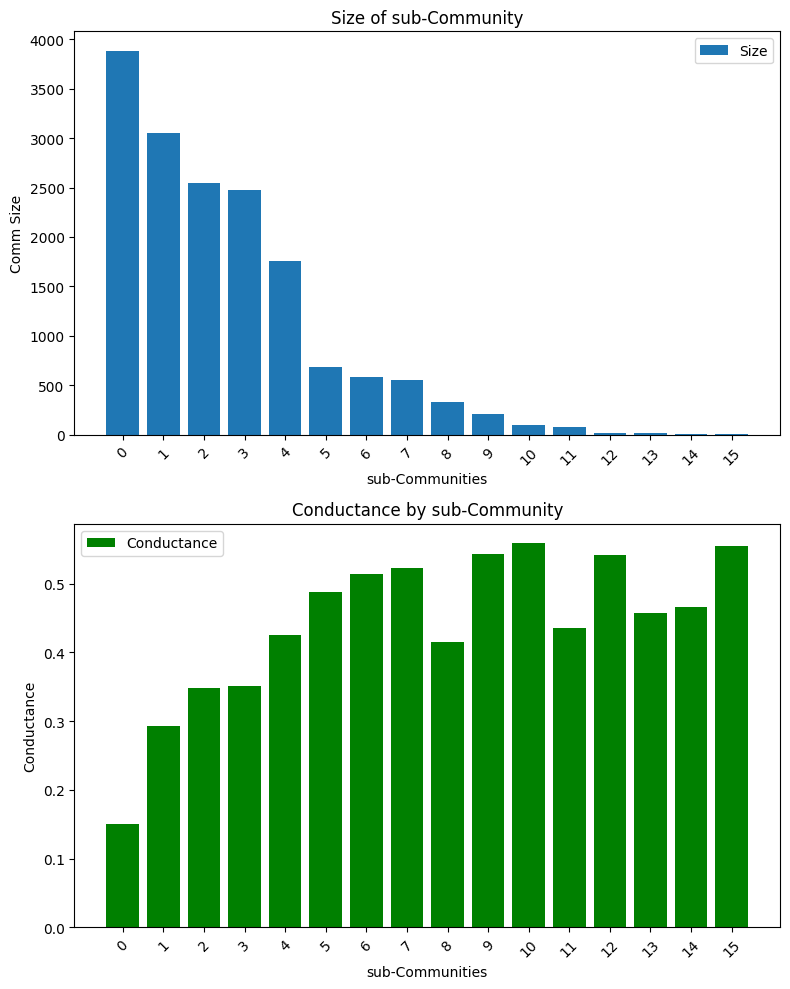

In [31]:
# Sizes and conductances of the sub-communites of the largest community: 
fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Increased figure size

labels = [f"{i}" for i in range(len(sub_comm_conductances))]
x = np.arange(len(labels))  # the label locations

# Plot for Comm Size
axs[0].bar(labels, sub_comm_sizes, label='Size')
axs[0].set_ylabel('Comm Size')
axs[0].set_title('Size of sub-Community')
axs[0].legend()

# Plot for Conductance
axs[1].bar(labels, sub_comm_conductances, color='g', label='Conductance')
axs[1].set_ylabel('Conductance')
axs[1].set_title('Conductance by sub-Community')
axs[1].legend()

for ax in axs:
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel('sub-Communities')

fig.tight_layout()  # Adjust layout to make sure everything fits without overlap

plt.show()